In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

import pickle
import time

import torch

import matplotlib.pyplot as plt
import defmod as dm
import model_graddesc as model

torch.set_default_tensor_type(torch.DoubleTensor)


#%%
dty = torch.float64
#source = torch.tensor([[-1., -1.], [1., 1.], [1., -1.], [-1., 1.]], requires_grad=True, dtype=dty)
#target = torch.tensor([[0., 0.], [2., 0.], [1., -1.], [1., 1.]], requires_grad=True, dtype=dty)

#target = torch.tensor([[-2., -2.], [2., 2.], [2., -2.], [-2., 2.]], requires_grad=True, dtype=dty)
#target = 1.+ torch.tensor([[-1., -1.], [1., 1.], [1., -1.], [-1., 1.]], requires_grad=True, dtype=dty)
def close_loop(oc):
    cc = np.zeros((np.shape(oc)[0]+1,2))
    cc[0:-1,:] = oc
    cc[-1][:] = oc[0][:]
    return cc
#%%


with open('../data/nuts/nutsdata.pickle', 'rb') as f:
    lines, sigv, sig = pickle.load(f)
source = torch.tensor(lines[0][::2], requires_grad=True, dtype=dty)[1:]

target = torch.tensor(lines[1][::2]  , requires_grad=True, dtype=dty)[1:]
num_target = 1

#target = torch.tensor(lines[7][::2]  , requires_grad=True, dtype=dty)[1:]
#num_target = 7

targets = [target]



pts_source = source.detach().numpy()
pts_target = target.detach().numpy()

#%%


sigma_scaling = 1.

#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%

In [2]:
scaling0 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)),sigma_scaling)
scaling1 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), sigma_scaling)

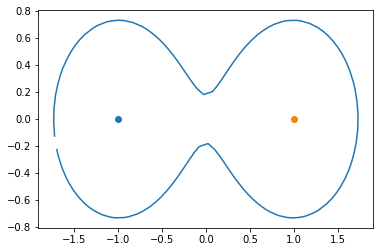

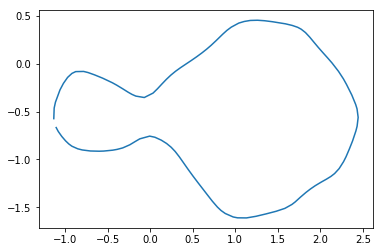

In [3]:
plt.figure()
plt.plot(pts_source[:,0], pts_source[:,1])
plt.scatter(gd0.detach().numpy()[:,0],gd0.detach().numpy()[:,1])
plt.scatter(gd1.detach().numpy()[:,0],gd1.detach().numpy()[:,1])

plt.show()

plt.figure()
plt.plot(pts_target[:,0], pts_target[:,1])
plt.show()


In [4]:
sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%
pts = f(gd0).detach().numpy()
vec = g(gd0).detach().numpy()
pts1 = f(gd1).detach().numpy()
vec1 = g(gd1).detach().numpy()


plt.quiver(pts[:,0], pts[:,1], vec[:,0], vec[:,1])
plt.quiver(pts1[:,0], pts1[:,1], vec1[:,0], vec1[:,1])
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.axis('equal')
#%%
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)), f, g, sigma_scaling)
scaling1 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), f, g, sigma_scaling)


In [5]:
silent = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(2, len(source), gd=source.view(-1)))
#silent_comp = dm.deformationmodules.CompoundModule([silent])
trans = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd = torch.tensor([0.,0.]).view(-1)), sigma=400, coeff=5.)
trans1 = dm.deformationmodules.Translations(dm.manifold.Landmarks(2, len(source), gd=source.view(-1)), sigma=0.2, coeff=10.)
mod = dm.deformationmodules.CompoundModule([silent, scaling0, scaling1, trans1, trans])
h = dm.hamiltonian.Hamiltonian(mod)

In [21]:
def attach(x,y):
    return dm.attachement.VarifoldAttachement([1, 0.2])([x], [y])

EnergyFunctional = model.EnergyFunctional_unconstrained(mod, h, source, targets, dim=2, gamma=0.01, attach=attach)

In [19]:
source.shape

torch.Size([120, 2])

In [20]:
attach = dm.attachement.VarifoldAttachement([1, 0.2])

attach([source], [target])

tensor(12.9332, grad_fn=<AddBackward0>)

In [22]:
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(h.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()

In [23]:
def fun(P, *args):
    #EnergyFunctional = args[0]
    gd0_tensor = gd0_tensor_init.clone()
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.energy_tensor(gd0_tensor, Y).detach().numpy()

In [24]:
def jac(P):
    #EnergyFunctional = args[0]
    gd0_tensor = gd0_tensor_init.clone()
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.gradE_autograd(gd0_tensor, Y).detach().numpy()

In [25]:
P0 = mom0_tensor.detach().numpy()
fun(P0)

cost: 0.0 attach: 12.933211334882209


array(12.933211334882209)

In [26]:
import scipy.optimize
res = scipy.optimize.minimize(fun, mom0_tensor.detach().numpy(),
                              method='BFGS',
                              jac=jac,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  'maxcor': 10,
                                  'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  'maxfun': 50,
                                  'maxiter': 20,
                                  'iprint': 1,
                                  'maxls': 25
                              })

/home/rosa/.local/share/miniconda2/envs/py3projects/lib/python3.6/site-packages/ipykernel_launcher.py:16: OptimizeWarning: Unknown solver options: maxcor, ftol, maxfun, iprint, maxls
  app.launch_new_instance()


cost: 0.0 attach: 12.933211334882209
cost: 0.0 attach: 12.933211334882209
cost: 0.249003474604 attach: 38.942639837254085
cost: 0.249003474604 attach: 38.942639837254085
cost: 0.0108196816368 attach: 7.565148483074159
cost: 0.0108196816368 attach: 7.565148483074159
cost: 0.0397955983564 attach: 11.128050252763979
cost: 0.0397955983564 attach: 11.128050252763979
cost: 0.0163350750774 attach: 5.182488052011556
cost: 0.0163350750774 attach: 5.182488052011556
cost: 0.0351003326792 attach: 9.583661892959071
cost: 0.0351003326792 attach: 9.583661892959071
cost: 0.0182899005688 attach: 4.496574611254456
cost: 0.0182899005688 attach: 4.496574611254456
cost: 0.0253017376373 attach: 9.04693127804061
cost: 0.0253017376373 attach: 9.04693127804061
cost: 0.0186145523623 attach: 4.424462058800911
cost: 0.0186145523623 attach: 4.424462058800911
cost: 0.0186476998257 attach: 4.281281782394064
cost: 0.0186476998257 attach: 4.281281782394064
cost: 0.0189111248307 attach: 3.75479921923756
cost: 0.0189111

In [27]:
P_opt = res.x
X = [gd0_tensor_init, torch.tensor(P_opt)]

In [28]:
%matplotlib inline
h.module.manifold.fill_gd(X[0])
h.module.manifold.fill_cotan(X[1])

In [29]:
states, controls = dm.shooting.shoot_euler(h, it=10)

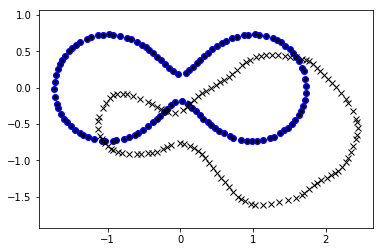

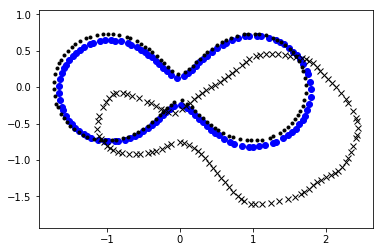

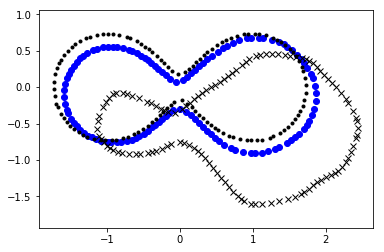

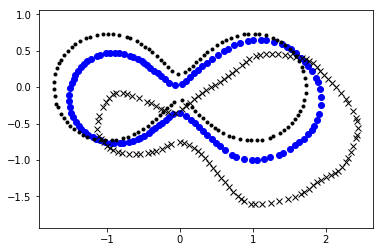

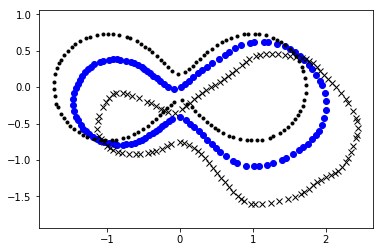

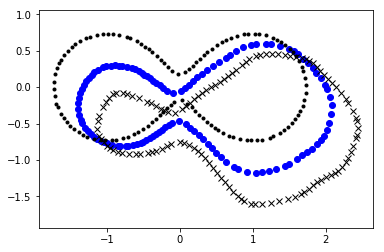

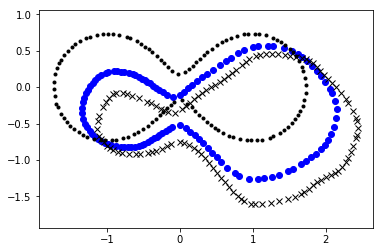

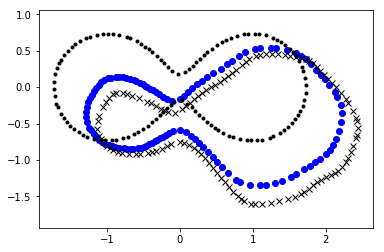

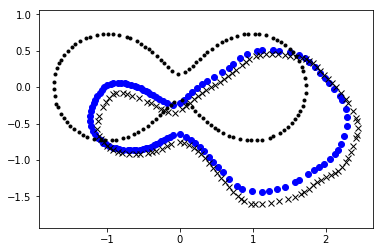

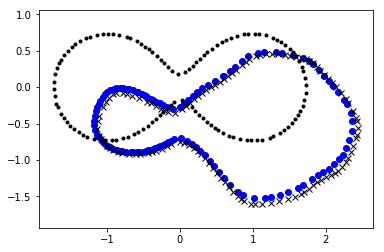

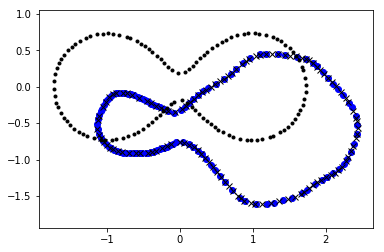

In [30]:
import numpy as np
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.figure()
    c = 'b'
    plt.scatter(s[0].gd.view(-1,2)[:, 0].detach().numpy(), s[0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[1][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[1][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.plot(targets[0][:, 0].detach().numpy(), targets[0][:, 1].detach().numpy(), 'xk')
    #plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    plt.plot(source[:, 0].detach().numpy(), source[:, 1].detach().numpy(), '.k')
    #plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')


    plt.axis('equal')
    plt.show()

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()